<h1><center>Laboratorio 9: Optimización de modelos 💯</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Primavera 2024</strong></center>

### **Cuerpo Docente:**

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliar: Eduardo Moya
- Ayudantes: Nicolás Ojeda, Melanie Peña, Valentina Rojas

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Cristobal Ramos 
- Nombre de alumno 2: Catalina Lizana


### **Link de repositorio de GitHub:** [Insertar Repositorio](https://github.com/...../)

### Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.

### Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Optimizar modelos usando `optuna`
- Recurrir a técnicas de *prunning*
- Forzar el aprendizaje de relaciones entre variables mediante *constraints*
- Fijar un pipeline con un modelo base que luego se irá optimizando.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# Importamos librerias útiles

In [1]:
!pip install -qq xgboost optuna

# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Al ver el gran potencial y talento que usted ha demostrado en el campo de la ciencia de datos, Fiu lo contrata como data scientist para que forme parte de su nuevo emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('sales.csv')

df.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,1,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,2,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,3,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,4,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7456 entries, 0 to 7455
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         7456 non-null   int64  
 1   date       7456 non-null   object 
 2   city       7456 non-null   object 
 3   lat        7456 non-null   float64
 4   long       7456 non-null   float64
 5   pop        7456 non-null   int64  
 6   shop       7456 non-null   object 
 7   brand      7456 non-null   object 
 8   container  7456 non-null   object 
 9   capacity   7456 non-null   object 
 10  price      7456 non-null   float64
 11  quantity   7456 non-null   int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 699.1+ KB


## 1 Generando un Baseline (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad. [0.5 puntos]
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas. [1 punto]
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas. `Nota:` Utilice el método `.set_output(transform='pandas')` para obtener un DataFrame como salida del `ColumnTransformer` [1 punto]
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios. [0.5 punto]
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio? [0.5 puntos]
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`? [1 punto]
7. Guarde ambos modelos en un archivo .pkl (uno cada uno) [0.5 puntos]

In [7]:
from sklearn import set_config
set_config(transform_output="pandas")


#1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad. 

from sklearn.model_selection import train_test_split

features = df.drop(columns =['quantity'])
labels = df.loc[:, 'quantity']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=24)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.18, random_state=25)


In [9]:
#2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas. 
from sklearn.preprocessing import FunctionTransformer

def extract_dates(dataframe):
    dates = pd.to_datetime(dataframe['date'], format='%d/%m/%y')
    dataframe['day'] = dates.dt.day.astype('category')
    dataframe['month'] = dates.dt.month.astype('category')
    dataframe['year'] = dates.dt.year.astype('category')
    
    return dataframe
    
transformer = FunctionTransformer(extract_dates)


In [11]:
#3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas. 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

c_transformer =  ColumnTransformer(transformers=[ ("categorical", OneHotEncoder(sparse_output=False), ['city', 'shop', 'brand','capacity', 'container','day','month', 'year']), ("numeric", StandardScaler(), ['lat', 'long', 'pop','price'])]).set_output(transform='pandas')

In [13]:
#4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios.
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

pipe_dummy = Pipeline([('Dates', transformer), ('Processing', c_transformer), ('Regresor', DummyRegressor())])


In [210]:
#5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio? 
from sklearn.metrics import mean_absolute_error
pipe_dummy.fit(X_train, y_train)
y_pred_dummy = pipe_dummy.predict(X_valid)
MAE_dummy = mean_absolute_error(y_valid, y_pred_dummy)
print(f"MAE_dummy_model = {MAE_dummy}")

MAE_dummy_model = 13369.603999508909


¿Cómo se interpreta esta métrica para el contexto del negocio?

RESPUESTA: Podemos interpretar que, en promedio, las predicciones de la demanda tienen un error de 13.369 en comparación a la demanda real.

In [208]:
#6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. 
from xgboost import XGBRegressor
pipe_xgb = Pipeline([('Dates', transformer), ('Processing', c_transformer), ('Regresor', XGBRegressor() )])
pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_valid)
MAE_xgb = mean_absolute_error(y_valid, y_pred_xgb)
print(f"MAE_xgb_model = {MAE_xgb}")

MAE_xgb_model = 2301.8063948675494


¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el DummyRegressor?

RESPUESTA: Mejora considerablemente al compararlo con el de Dummy. El error disminuye aproximadamente en un 80%, con respecto al error del dummy_model

## 2. Forzando relaciones entre parámetros con XGBoost (10 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline` con `XGBRegressor`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Para aplicar esta restricción apóyese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>. [6 puntos]

>Hint 1: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

>Hint 2: Puede obtener el nombre de las columnas en el paso anterior al modelo regresor mediante el método `.get_feature_names_out()`

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. [1 puntos]

3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo? [2 puntos]

4. Guarde su modelo en un archivo .pkl [1 punto]

In [21]:
pipe_xgb['Processing'].get_feature_names_out()

array(['categorical__city_Athens', 'categorical__city_Irakleion',
       'categorical__city_Larisa', 'categorical__city_Patra',
       'categorical__city_Thessaloniki', 'categorical__shop_shop_1',
       'categorical__shop_shop_2', 'categorical__shop_shop_3',
       'categorical__shop_shop_4', 'categorical__shop_shop_5',
       'categorical__shop_shop_6', 'categorical__brand_adult-cola',
       'categorical__brand_gazoza', 'categorical__brand_kinder-cola',
       'categorical__brand_lemon-boost',
       'categorical__brand_orange-power', 'categorical__capacity_1.5lt',
       'categorical__capacity_330ml', 'categorical__capacity_500ml',
       'categorical__container_can', 'categorical__container_glass',
       'categorical__container_plastic', 'categorical__day_28',
       'categorical__day_29', 'categorical__day_30',
       'categorical__day_31', 'categorical__month_1',
       'categorical__month_2', 'categorical__month_3',
       'categorical__month_4', 'categorical__month_5',
      

In [45]:
#1. Vuelva a entrenar el `Pipeline` con `XGBRegressor`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. 

params = {}
params['monotone_constraints'] = {'numeric__price': -1}

pipe_xgb_ctr = Pipeline([('Dates', transformer), ('Processing', c_transformer), ('Regresor', XGBRegressor(**params))])

In [212]:
#2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. 
pipe_xgb_ctr.fit(X_train, y_train)
y_pred_xgb_ctr = pipe_xgb_ctr.predict(X_valid)
MAE_xgb_ctr = mean_absolute_error(y_valid, y_pred_xgb_ctr)
print(f"MAE_xgb_ctr_model = {MAE_xgb_ctr}")

MAE_xgb_ctr_model = 2417.2837138397012


In [214]:
#3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo?
print(f"MAE_dummy_model   = {MAE_dummy}")
print(f"MAE_xgb_model     = {MAE_xgb}")
print(f"MAE_xgb_ctr_model = {MAE_xgb_ctr}")

MAE_dummy_model   = 13369.603999508909
MAE_xgb_model     = 2301.8063948675494
MAE_xgb_ctr_model = 2417.2837138397012


RESPUESTA: El error aumenta, aunque no de manera considerable, por ende, podemos afirmar que el precio si guarda una relación inversa con la cantidad pero no de manera significativa.


In [56]:
#4. Guarde su modelo en un archivo .pkl
import pickle
with open('pipe_xgb_ctr.pkl', 'wb') as file:
    pickle.dump( pipe_xgb_ctr, file)

## 1.3 Optimización de Hiperparámetros con Optuna (20 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se pide que su optimización considere lo siguiente:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)

Para ello se pide los siguientes pasos:
1. Implemente una función `objective()` que permita minimizar el `MAE` en el conjunto de validación. Use el método `.set_user_attr()` para almacenar el mejor pipeline entrenado. [10 puntos]
2. Fije el tiempo de entrenamiento a 5 minutos. [1 punto]
3. Optimizar el modelo y reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
4. Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados? [5 puntos]
5. Guardar su modelo en un archivo .pkl [1 punto]

In [58]:
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [85]:
#1. Implemente una función `objective()` que permita minimizar el `MAE` en el conjunto de validación. Use el método `.set_user_attr()` 
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        "objective": 'reg:squarederror',
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_leaves":trial.suggest_int("max_leaves", 0, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "reg_alpha": trial.suggest_float("reg_alpha",0,1),
        "reg_lambda": trial.suggest_float("reg_lambda",0,1),
    }
    params_OHE ={"min_frequency": trial.suggest_float("min_frequency", 0, 1)}

    c_transformer =  ColumnTransformer(transformers=[ ("categorical", OneHotEncoder(sparse_output=False,min_frequency=params_OHE["min_frequency"]), ['city', 'shop', 'brand','capacity', 'container','day','month', 'year']), ("numeric", StandardScaler(), ['lat', 'long', 'pop','price'])]).set_output(transform='pandas')
    model = Pipeline([('Dates', transformer), ('Processing', c_transformer), ('Regresor', XGBRegressor(seed =26,**params) )])
    model.fit(X_train, y_train)

    # Predict and evaluate the model
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)  

    trial.set_user_attr("mae", mae)
    trial.set_user_attr("params", params)
    
    return mae 
    

In [125]:
#2. Fije el tiempo de entrenamiento a 5 minutos. 
train_time = 5*60

#3. Optimizar el modelo y reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados.
study_optuna = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize")
study_optuna.optimize(objective, timeout=train_time)

In [243]:
MAE_optuna = study_optuna.best_value
print(f"MAE_Optuna = {MAE_optuna}")
print(f"Best_params_Optuna = {study_optuna.best_params}")
#print(f"Best_trial_Optuna = {study_optuna.best_trial}")
print(f"Len_Optuna = {len(study_optuna.trials)}")

MAE_Optuna = 1901.2106003919184
Best_params_Optuna = {'learning_rate': 0.06491578211773985, 'n_estimators': 944, 'max_depth': 7, 'max_leaves': 50, 'min_child_weight': 5, 'reg_alpha': 0.7221977204399269, 'reg_lambda': 0.24108588469794123, 'min_frequency': 0.07299893733895958}
Len_Optuna = 137


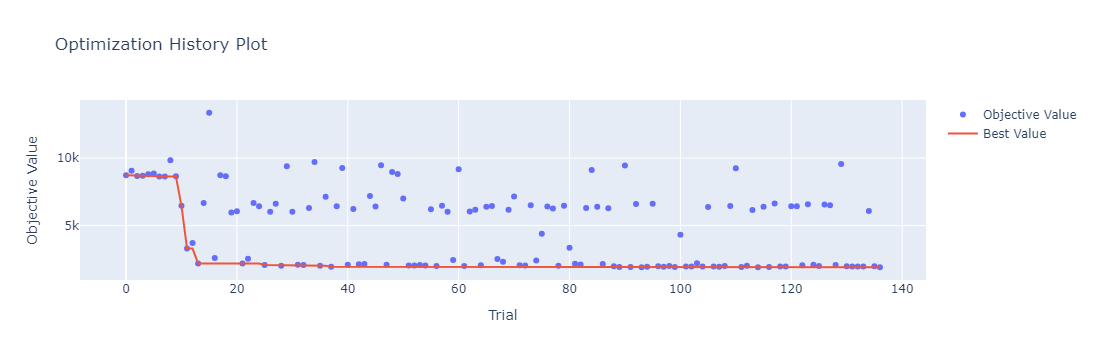

In [229]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study_optuna)

¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?

RESPUESTA: Los resultados son mejores que los 3 obtenidos en las secciones anteriores, esto se debe principalmente al uso de hiperparámetros ajustados exclusivamente para este problema.

4. Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados?

* learning_rate: Determina la tasa de aprendizaje con la que el modelo "aprenderá" en cada iteración.
* n_estimators: Es el número estimadores de tipo árboles de decisión qeu utilizará el modelo.
* max_depth: Máximo de profundidad de cad árbol de decisión. 
* max_leaves: Número máximo de hojas permitidas en cada árbol de decisión.
* min_child_weight: Fija el peso mínimo que tienen qeu tener las hojas de los árboles de decisión para que se subdividan (y dejen de ser hojas).
* reg_alpha: Coeficiente de regularización L1, utilizado para penalizar el modelo.
* reg_lambda: Coeficiente de regularización L2, utilizado para penalizar el modelo.
* min_frequency: Fija el mínimo de frecuencia que deben tener las variables categóricas para ser codificadas. 

El ajuste de estos hiperparámetros permite mejorar los resultados del modelo y a la vez evitar el sobreajuste del mismo. 

Los rangos de optimización parecen tener sentido, pensando en que cada uno de los hiperparámetros explicados arriba, si toman valores muy grandes o muy pequeños, pueden generar sobreajuste en el modelo, por lo que es coeherente ajustar sus rangos a valores que sigan siendo realistas. 

In [133]:
# 5. Guardar su modelo en un archivo .pkl 
params = study_optuna.best_params
params_OHE = params['min_frequency']
params.pop('min_frequency')

c_transformer =  ColumnTransformer(transformers=[ ("categorical", OneHotEncoder(sparse_output=False,min_frequency=params_OHE), ['city', 'shop', 'brand','capacity', 'container','day','month', 'year']), ("numeric", StandardScaler(), ['lat', 'long', 'pop','price'])]).set_output(transform='pandas')
optuna_model = Pipeline([('Dates', transformer), ('Processing', c_transformer), ('Regresor', XGBRegressor(seed =26,**params) )])

with open('optuna_model.pkl', 'wb') as file:
    pickle.dump(optuna_model, file)

## 4. Optimización de Hiperparámetros con Optuna y Prunners (17 puntos)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento? [2 puntos]
- Redefinir la función `objective()` utilizando `optuna.integration.XGBoostPruningCallback` como método de **Prunning** [10 puntos]
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos [1 punto]
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
- Guardar su modelo en un archivo .pkl [1 punto]

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

In [135]:
#!pip install optuna-integration[xgboost]
optuna.logging.set_verbosity(optuna.logging.WARNING)

1. ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento?

RESPUESTA: Pruning se refiere a la técnica de "podar", en el sentido de eliminar conexiones (o neuronas en el caso de redes neuronales) con el objetivo de optimizar el modelo, reduciendo la su complejidad y aumentando la eficiencia del mismo. En este caso el pruning elimina los intentos que tienden a disminuir el desempeño final del modelo. 

Esto debería impactar de manera positiva el entrenamiento del modelo, pues al bajar la complejidad aumenta la posibilidad de obtener un mejor aprendizaje, y luego, mejores predicciones. 


In [290]:
#2. Redefinir la función objective() utilizando optuna.integration.XGBoostPruningCallback como método de Prunning 

def objective(trial):
    # Define the hyperparameters to tune
    params = {
        "objective": 'reg:squarederror',
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_leaves":trial.suggest_int("max_leaves", 0, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "reg_alpha": trial.suggest_float("reg_alpha",0,1),
        "reg_lambda": trial.suggest_float("reg_lambda",0,1),
    }
    params_OHE ={"min_frequency": trial.suggest_float("min_frequency", 0, 1)}

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, observation_key='mae')

    c_transformer =  ColumnTransformer(transformers=[ ("categorical", OneHotEncoder(sparse_output=False, min_frequency=params_OHE["min_frequency"]), ['city', 'shop', 'brand','capacity', 'container','day','month', 'year']), ("numeric", StandardScaler(), ['lat', 'long', 'pop','price'])]).set_output(transform='pandas')
    model = Pipeline([('Dates', transformer), ('Processing', c_transformer), ('Regresor', XGBRegressor(seed=26, **params) )])
    
    model.fit(X_train, y_train)
    #    model.fit(X_train, y_train, Regresor__eval_set=[(X_train, y_train), (X_valid, y_valid)], Regresor__callbacks=[pruning_callback])

    # Predict and evaluate the model
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)  

    trial.set_user_attr("mae", mae)
    trial.set_user_attr("params", params)
    
    return mae 
    

In [292]:
#3. Fijar nuevamente el tiempo de entrenamiento a 5 minutos 
train_time = 5*60

#4. Reportar el número de trials, el MAE y los mejores hiperparámetros encontrados. 
study_optuna_pruning = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize")
study_optuna_pruning.optimize(objective, timeout=train_time, show_progress_bar = True)

   0%|          | 00:00/05:00

In [293]:
MAE_optuna_pruning = study_optuna_pruning.best_value
print(f"MAE_Optuna_pruning = {MAE_optuna_pruning}")
print(f"Best_params_Optuna_pruning = {study_optuna_pruning.best_params}")
#print(f"Best_trial_Optuna_pruning = {study_optuna_pruning.best_trial}")
print(f"Len_Optuna_pruning = {len(study_optuna_pruning.trials)}")

MAE_Optuna_pruning = 1823.9205247487453
Best_params_Optuna_pruning = {'learning_rate': 0.08222314033086457, 'n_estimators': 913, 'max_depth': 7, 'max_leaves': 68, 'min_child_weight': 3, 'reg_alpha': 0.5773162471942738, 'reg_lambda': 0.05097961357729251, 'min_frequency': 0.052556998273338824}
Len_Optuna_pruning = 120


In [294]:
print(f"MAE_Optuna         = {study_optuna.best_value}, Len_Optuna         = {len(study_optuna.trials)}")
print(f"MAE_Optuna_pruning = {study_optuna_pruning.best_value}, Len_Optuna_pruning = {len(study_optuna_pruning.trials)}")

MAE_Optuna         = 1901.2106003919184, Len_Optuna         = 137
MAE_Optuna_pruning = 1823.9205247487453, Len_Optuna_pruning = 120


¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?

RESPUESTA: El modelo Optuna utilizando la técnica "pruning" obtiene un menor error absoluto que el anterior modelo (Optuna sin pruning). Efectivamente, esto da cuenta de las mejoras en el entrenamiento obtenidas por la disminución de complejidad del modelo obtenida por la "poda". 

In [296]:
#5. Guardar su modelo en un archivo .pkl 
params= study_optuna_pruning.best_params
params_OHE= params["min_frequency"]
params.pop('min_frequency', None)


c_transformer =  ColumnTransformer(transformers=[ ("categorical", OneHotEncoder(sparse_output=False,min_frequency=params_OHE), ['city', 'shop', 'brand','capacity', 'container','day','month', 'year']), ("numeric", StandardScaler(), ['lat', 'long', 'pop','price'])]).set_output(transform='pandas')
optuna_pruning_model = Pipeline([('Dates', transformer), ('Processing', c_transformer), ('Regresor', XGBRegressor(seed =26,**params) )])

with open('optuna_pruning_model.pkl', 'wb') as file:
    pickle.dump(optuna_pruning_model, file)
    


## 5. Visualizaciones (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gráfico de historial de optimización [1 punto]
2. Gráfico de coordenadas paralelas [1 punto]
3. Gráfico de importancia de hiperparámetros [1 punto]

Comente sus resultados:

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? [0.5 puntos]
5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? [1 punto]
6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo? [0.5 puntos]

Optuna Pruning model


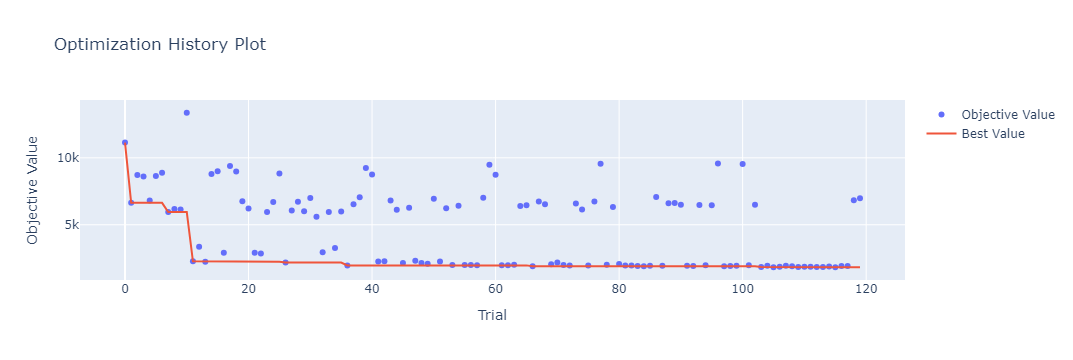

In [297]:
# 1. Gráfico de historial de optimización 
from optuna.visualization import plot_optimization_history
print("Optuna Pruning model")
plot_optimization_history(study_optuna_pruning)


4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados?

RESPUESTA: En el *trial* 3 realiza una gran mejora, luego en el *trial* 10 y finalemente en el *trial* 17. A partir de este, los resultados no presentan grandes mejoras. 

Optuna Pruning model


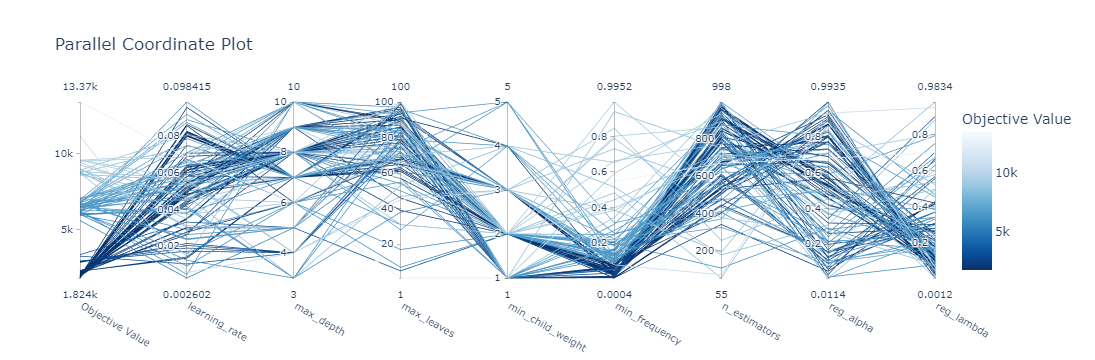

In [334]:
# 2. Gráfico de coordenadas paralelas 
from optuna.visualization import plot_parallel_coordinate
print("Optuna Pruning model")
plot_parallel_coordinate(study_optuna_pruning)

5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? 

RESPUESTA: Como las líneas de color obscuro marcan valores más pequeños de la función objetivo, estas representan las mejores configuración de parámetros. Entre ellas se destaca la utilización de un bajo "min_frecuency", alto "max_leaves" y alto "n_estimators". 


Optuna Pruning model


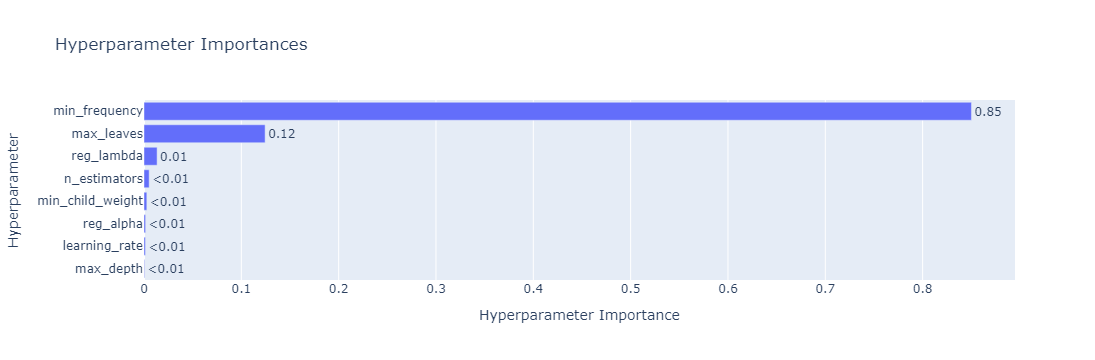

In [302]:
# 3. Gráfico de importancia de hiperparámetros
from optuna.visualization import plot_param_importances
print("Optuna Pruning model")
plot_param_importances(study_optuna_pruning)


6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo?

RESPUESTA: El hiperparámetro más importante es la variable "min_frecuency", la cual se "lleva" el *97%* de la importancia a la hora de predecir. 

## 6. Síntesis de resultados (3 puntos)

Finalmente:

1. Genere una tabla resumen del MAE en el conjunto de validación obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning. [1 punto]
2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento? [0.5 puntos]
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE. [0.5 puntos]
4. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto? [1 punto]

In [305]:
#1 Tabla de resumen:
data_MAE = {"Model": ["Baseline_dummy", "XGBRegressor", "XGBRegressor_ctr", "Optuna", "Optuna_Prunners"], 
            "MAE": [MAE_dummy, MAE_xgb, MAE_xgb_ctr, MAE_optuna, MAE_optuna_pruning]}

df_MAE_models = pd.DataFrame(data=data_MAE)
df_MAE_models["MAE"] = df_MAE_models.MAE.round(2)
df_MAE_models

,Model,MAE
0,Baseline_dummy,13369.60
1,XGBRegressor,2301.81
2,XGBRegressor_ctr,2417.28
3,Optuna,1901.21
4,Optuna_Prunners,1823.92


2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento? 

RESPUESTA: El modelo que consigue un mejor rendimiento es Optuna_Prunners con un MAE de $1874.79$. 


In [319]:
#4. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE. [0.5 puntos]
optuna_pruning_model.fit(X_train, y_train)
y_pred_test = optuna_pruning_model.predict(X_test)
mae_in_test = mean_absolute_error(y_test, y_pred_test)  
print(f"MAE_optuna_pruning_model en test_set = {mae_in_test}")

MAE_optuna_pruning_model en test_set = 1995.8434145520903


6. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto?

RESPUESTA: Si, la méttrica de MAE en el conjunto de test es un poco mayor al cálculo en el conjunto de validación. Esto sucede pues hay datos distintos en cada conjunto, y para distintos datos, el error absoluto promedio puede cambiar. 

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://media.tenor.com/8CT1AXElF_cAAAAC/gojo-satoru.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>